In [8]:
from dataset import AIArtBenchDataset
from torch.utils.data import DataLoader
import torch
import timm
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.transforms import Resize, Normalize, Compose, ToTensor, Lambda
from torchvision.models import resnet50
import torch.nn as nn

root = '/home/amk/data/Real_AI_SD_LD_Dataset'

train_data = AIArtBenchDataset(
    root=root,
    for_training=False,
    transforms=None,
    target_transforms=None
)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    Lambda(lambda x: x.float()),  # Convert images to float tensors
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=mean, std=std)
])

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
])

(-0.5, 298.5, 298.5, -0.5)

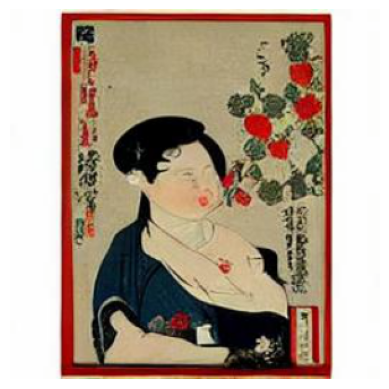

In [13]:
img, label = train_data[2000]
img = transform(img).reshape((1, 3, 299, 299))
img_grad = torch.tensor(img.numpy(), requires_grad=True)

plt.imshow(reverse_transform(img_grad).to(torch.int16).detach().reshape((3, 299, 299)).permute(1, 2, 0))
plt.axis('off')

In [14]:
class MyResNet(nn.Module):
    def __init__(self, num_classes, is_pretrained=False):
        super(MyResNet, self).__init__()

        # Instantiate a pretrained/randomly-initialized resnet model
        self.resnet_model = resnet50(pretrained=is_pretrained)

        # Modify last layer to map to 3 output classes
        in_features = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet_model(x)

model = MyResNet(num_classes=3, is_pretrained=False)
model.load_state_dict(torch.load('resnet_model.pth'))

for param in model.parameters():
    param.requires_grad = False

model2 = timm.create_model('efficientnet_b4', pretrained=False, num_classes=3) #pretrained on imagenet
model2.load_state_dict(torch.load('efficient_model.pth'))

model3 = models.inception_v3(pretrained=False)
model3.fc = torch.nn.Linear(model3.fc.in_features, 3)
model3.load_state_dict(torch.load('inception_model.pth'))

/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>

Start losses (Resnet)): tensor([[-8.8427,  5.8806, -3.7311]], grad_fn=<AddmmBackward0>)
Start losses (EfficientNet)): tensor([[-65.9777, 214.1525, -13.0303]], grad_fn=<AddmmBackward0>)
Start losses (Inception)): tensor([[-15.0119,  11.7803,  -8.4142]], grad_fn=<AddmmBackward0>)
epoch 1: loss = 9.611761093139648
epoch 2: loss = 0.0016175531782209873
epoch 3: loss = 1.9311717551317997e-05
epoch 4: loss = 1.7881233361549675e-05
epoch 5: loss = 2.0265373677830212e-05
epoch 6: loss = 2.396077979938127e-05
epoch 7: loss = 3.755022044060752e-05
epoch 8: loss = 5.400034933700226e-05
epoch 9: loss = 7.354942499659956e-05
epoch 10: loss = 9.810443589231e-05
epoch 11: loss = 0.0001262346631847322
epoch 12: loss = 0.00018380382971372455
epoch 13: loss = 0.00023910524032544345
epoch 14: loss = 0.00026127262390218675
epoch 15: loss = 0.0002588890492916107
epoch 16: loss = 0.0002277830062666908
epoch 17: loss = 0.0001954841281985864
epoch 18: loss = 0.00015758226800244302
epoch 19: loss = 0.000153172

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


End losses (Inception)): tensor([[ 2.7180, -3.6406, -1.7485]], grad_fn=<AddmmBackward0>)


(-0.5, 298.5, 298.5, -0.5)

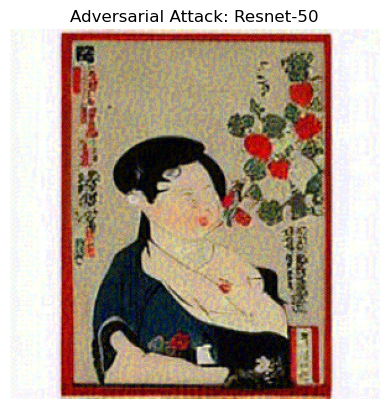

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([img_grad], lr=10)

target_class_label = 2
target = torch.Tensor([target_class_label]).long()

model.eval()
model2.eval()
model3.eval()

print(f'Start losses (Resnet)): {model(img_grad)}')
print(f'Start losses (EfficientNet)): {model2(img_grad)}')
print(f'Start losses (Inception)): {model3(img_grad)}')

num_epochs = 50
for epoch in range(1, num_epochs+1):
    optimizer.zero_grad()
    output = model(img_grad)
    loss = criterion(output, target)
    loss.backward()

    optimizer.step()

    print(f'epoch {epoch}: loss = {loss}')


print(f'End losses (EfficientNet)): {model(img_grad)}')
print(f'End losses (ResNet)): {model2(img_grad)}')
print(f'End losses (Inception)): {model3(img_grad)}')

plt.imshow(reverse_transform(img_grad).to(torch.int16).detach().reshape((3, 299, 299)).permute(1, 2, 0))
plt.title('Adversarial Attack: Resnet-50')
plt.axis('off')